In [1]:
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn import metrics

# Basic EDA

In [3]:
train_df = pd.read_csv('data/train.csv')

<BarContainer object of 7 artists>

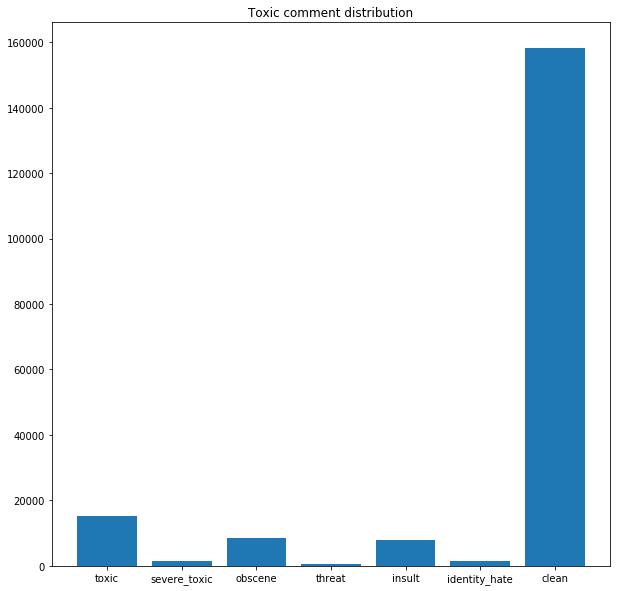

In [4]:
labels = train_df.iloc[:, 2:].keys().tolist()

label_count = []
for label in labels:
    label_count.append(train_df.loc[train_df[label] == 1]['id'].count())

labels.append('clean')
label_count.append(
    train_df.loc[train_df[label] == 0]['id'].count()
)

plt.figure(figsize=(10, 10))
plt.title('Toxic comment distribution')
plt.bar(labels, label_count)

<BarContainer object of 7 artists>

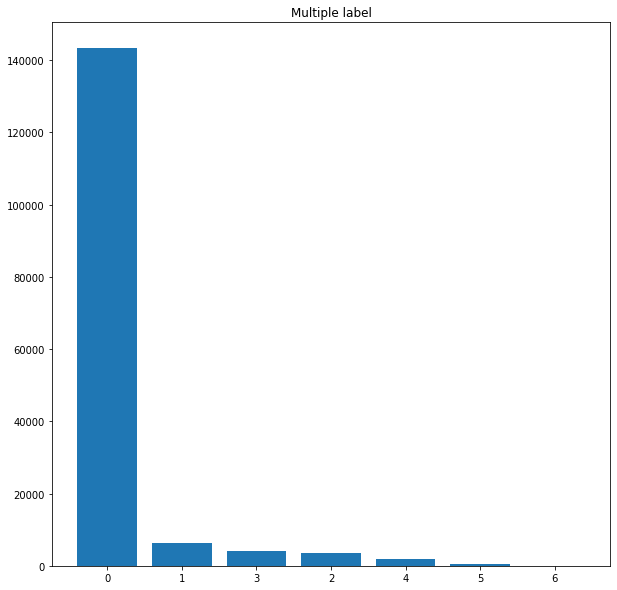

In [5]:
multi_labels = train_df.iloc[:, 2:].sum(axis=1).value_counts()

plt.figure(figsize=(10, 10))
plt.title('Multiple label')
plt.bar(multi_labels.keys().astype(str), multi_labels.values)

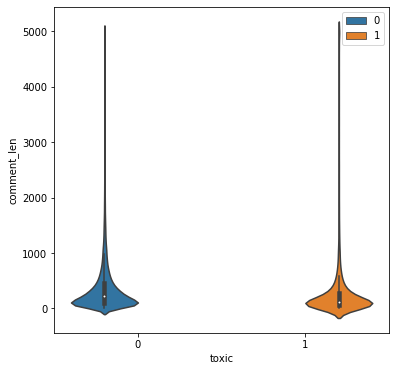

In [6]:
# Check if length of comment plays any role in toxicity
train_df['comment_len'] = train_df['comment_text'].apply(lambda x: len(x))

plt.figure(figsize=(6, 6))

sns.violinplot(x='toxic', y='comment_len', data=train_df, hue='toxic')
plt.legend()
del train_df['comment_len']

# Build model and train

In [7]:
# Set gpu for torch
# Remember torch sets tensor variables for gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080


In [8]:
# Pre processing data
train_df['list'] = train_df.iloc[:, 2:].values.tolist()
new_train_df = train_df[['comment_text', 'list']].copy()
new_train_df.head()

,comment_text,list
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

batch_size = 16
epochs = 3
learning_rate = 1e-05
max_len = 200

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len
        
    def __len__(self):
        return len(self.comment_text)
    
    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())
        
        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [11]:
train_data = new_train_df.sample(frac=0.8, random_state=200)
test_data = new_train_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(new_train_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = CustomDataset(train_data, tokenizer, max_len)
test_set = CustomDataset(test_data, tokenizer, max_len)

FULL Dataset: (159571, 2)
TRAIN Dataset: (127657, 2)
TEST Dataset: (31914, 2)


In [12]:
training_params = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': batch_size,
    'shuffle': False,
    'num_workers': 0
}


training_loader = DataLoader(training_set, **training_params)
test_loader = DataLoader(test_set, **test_params)

In [13]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
        
    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output
    
model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [14]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [15]:
for epoch in range(epochs):
    # Set to train mode
    model.train()
    
    # Loop for training
    for index, data in enumerate(training_loader, 0):
        # Remember torch assigns gpu to tensor variables
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        
        # Zero output gradients
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        if index % 500 == 0:
            print('Current Index: {}'.format(index))
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Loop for validation
    print("Running Validation...")
    
    # Set model to eval mode
    model.eval()
    
    fin_outputs = []
    fin_targets = []
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets  = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    fin_outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
    f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro')
    
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

Current Index: 0
Epoch: 0, Loss:  0.6449424624443054
Current Index: 500
Epoch: 0, Loss:  0.14037279784679413
Current Index: 1000
Epoch: 0, Loss:  0.044474199414253235
Current Index: 1500
Epoch: 0, Loss:  0.08411286771297455
Current Index: 2000
Epoch: 0, Loss:  0.059244006872177124
Current Index: 2500
Epoch: 0, Loss:  0.053552281111478806
Current Index: 3000
Epoch: 0, Loss:  0.02199537307024002
Current Index: 3500
Epoch: 0, Loss:  0.09398774802684784
Current Index: 4000
Epoch: 0, Loss:  0.10587098449468613
Current Index: 4500
Epoch: 0, Loss:  0.01164447795599699
Current Index: 5000
Epoch: 0, Loss:  0.030690131708979607
Current Index: 5500
Epoch: 0, Loss:  0.03509323298931122
Current Index: 6000
Epoch: 0, Loss:  0.0459524542093277
Current Index: 6500
Epoch: 0, Loss:  0.050504252314567566
Current Index: 7000
Epoch: 0, Loss:  0.1202787384390831
Current Index: 7500
Epoch: 0, Loss:  0.024818694218993187
Running Validation...
Accuracy Score = 0.9273986338284138
F1 Score (Micro) = 0.7742034079